# kmeans clustering

The goal of this notebook is to:
1. Present a Spark implementation of kmeans
2. Illustrate the effect of initialization on kmeans
3. Introduce kmeans++ initialization

## Simulated data set

In [1]:
file_name = "data-30-clusters-1000-points.txt"
k = 30

In [2]:
import matplotlib.pyplot as plt
import math

def plot_data(data_file):
    color=[]
    x=[]
    y=[]
    area=[]
    with open(data_file) as f:
        lines = f.readlines()
    for line in lines:
        xx,yy=str.split(line)
        color.append(0)
        area.append(math.pi*6**2)
        x.append(float(xx))
        y.append(float(yy))
    
    plt.scatter(x,y,c=color)
    plt.show()

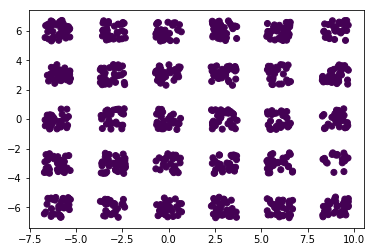

In [3]:
plot_data(file_name)

## kmeans implementation

In [4]:
# Spark initialization
import pyspark
conf = pyspark.SparkConf().setAppName("kmeans").setMaster("local")
sc = pyspark.SparkContext(conf=conf)

In [5]:
# Helper functions
def distance2(x, y):
    '''
    The Euclidean squared distance between two 2D points
    '''
    return (x[0]-y[0])**2+(x[1]-y[1])**2

def closest_centroid(x, C):
    '''
    x: a data point
    C: a set of data points (centroids)
    Returns the centroid in C which is closest to x
    '''
    current = 0
    min_dist = distance2(x, C[current])
    for index, c in enumerate(C):
        d = distance2(x, c)
        if d < min_dist:
            current = index
            min_dist = d
    return current

def addpairs(p, q):
    '''
    Pairs are in the following format: p = (x, n)
    Where x is a data point and n is the number of data points that were sumed to
    obtain x.
    '''
    (x, a) = p
    (y, b) = q
    z = [x[0]+y[0], x[1]+y[1]]
    c = a + b
    return (z, c)

def init_kmeans(points, k):
    '''
    Just a random sampling of k points in points.
    '''
    return points.takeSample(False, k)

### Kmeans implementation

def kmeans(file_name, k, init_function, sc):
    '''
    file_name: a set of 2D data points, 1 per line, x and y coordinates separated by space
    k: desired number of clusters
    init_function: function to use to initialize centroids
    sc: Spark context
    '''
    
    # Read data and cast to float
    points=sc.textFile(file_name).map(lambda x: x.split(" ")).\
            map(lambda pair: (float(pair[0]), float(pair[1])))
    
    # Initialization
    centroids=init_function(points, k)
    init_centroids=centroids

    # kmeans
    max_it=100  # this could have been a parameter
    old_centroids=[]
    for i in range(0, max_it):
        print("kmeans iteration "+str(i))
        # Assign points to centroids (in parallel)
        # and recompute centroids 
        points_assigned = points.map(
            lambda x: (closest_centroid(x, centroids), (x, 1))
        )
        centroid_pairs=points_assigned.reduceByKey(
            lambda x,y: addpairs(x,y)
        )
        # Finish centroid computation
        centroids = []
        for pair in centroid_pairs.collect(): # there are only k centroids, so it fits in memory
            _, (c, count) = pair
            centroids.append((c[0]/count, c[1]/count))
        # Check convergence
        if sorted(centroids) == sorted(old_centroids): # you might want to be less stringent
            break
        old_centroids = centroids

    # Formatting for convenience
    points_assigned = points_assigned.map(lambda x: (x[0], x[1][0][0], x[1][0][1]))
    return (points_assigned, centroids, init_centroids)

## First test

In [6]:
(points_assigned, centroids, init_centroids) = kmeans(file_name, k, init_kmeans, sc)

kmeans iteration 0
kmeans iteration 1
kmeans iteration 2
kmeans iteration 3
kmeans iteration 4
kmeans iteration 5
kmeans iteration 6
kmeans iteration 7
kmeans iteration 8
kmeans iteration 9
kmeans iteration 10


Note the number of iterations required for convergence.

In [7]:
import math
from matplotlib import pyplot as plt

def plot_result(points_assigned, centroids, no_color=False):
      # plot points
      color=[]
      x=[]
      y=[]
      area=[]
      for p in points_assigned.collect():
        (c,xx,yy) = p
        if no_color:
            color.append("black")
        else:
            color.append(int(c))
        area.append(math.pi*6**2)
        x.append(float(xx))
        y.append(float(yy))
      plt.scatter(x,y,c=color,s=area)

      # plot centroids
      color=[]
      x=[]
      y=[]
      area=[]
      for c in centroids:
        (xx,yy) = c
        color.append("red")
        area.append(30)
        x.append(xx)
        y.append(yy)
      plt.scatter(x,y,c=color,s=area)

      plt.show()

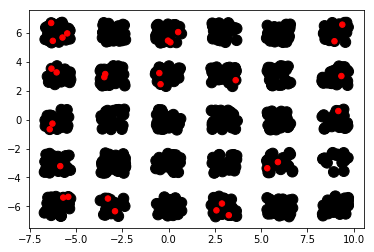

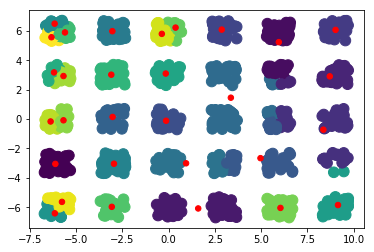

In [8]:
plot_result(points_assigned, init_centroids, True)
plot_result(points_assigned, centroids)

Note the "imperfection" of the clustering.

## Effect of initialization

Let's run kmeans a second time. Only initialization will change compared to the first run.

In [9]:
(points_assigned, centroids, init_centroids) = kmeans(file_name, k, init_kmeans, sc)

kmeans iteration 0
kmeans iteration 1
kmeans iteration 2
kmeans iteration 3
kmeans iteration 4
kmeans iteration 5
kmeans iteration 6
kmeans iteration 7
kmeans iteration 8


Note the number of iterations required for convergence.

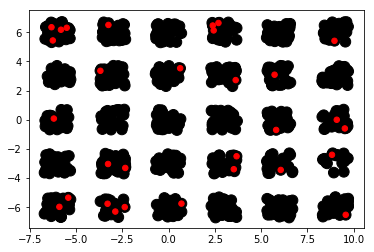

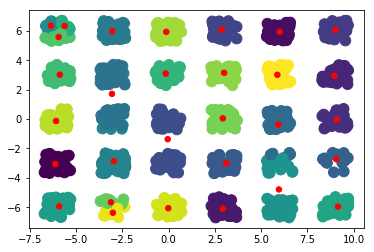

In [11]:
plot_result(points_assigned, init_centroids, True)
plot_result(points_assigned, centroids)

Results are quite different from the previous iteration.

## kmeans++

kmeans++ are a method to improve initialization. It tries to sample initialization points far from each other.

It was described in:
D. Arthur and S. Vassilvitskii. k-means++: The
advantages of careful seeding. In SODA, pages
1027–1035, 2007.

Algorithm (extracted from paper):
![kmeans++](kmeans++.png)

In [12]:
import random

def distance2_set(x, C):
    '''
    Squared distance between a point x and the set of centroids C, defined as the shortest
    distance with any centroid.
    '''
    min_dist = distance2(x, C[0])
    for c in C:
        d = distance2(x, c)
        if d < min_dist:
            min_dist = d
    return min_dist

def phi(X, C):
    '''
    Sum of the squared distances between points in X and centroids in C.
    '''
    sum = 0
    for x in X:
        sum += distance2_set(x, C)
    return sum


def init_kmeans_plus_plus(points, k):
    # take a random point
    point_list = points.collect()
    centroids = random.sample(point_list, 1)
    phi_value = phi(point_list, centroids)
    while len(centroids) < k:
        for x in point_list:
            proba = distance2_set(x, centroids)/phi_value
            if random.random() < proba: # sample a point with probability 'proba'
                centroids.append(x)
                phi_value = phi(point_list, centroids)
                if len(centroids) == k:
                    break
    return centroids

In [13]:
(points_assigned, centroids, init_centroids) = kmeans(file_name, k, init_kmeans_plus_plus, sc)

kmeans iteration 0
kmeans iteration 1
kmeans iteration 2
kmeans iteration 3
kmeans iteration 4
kmeans iteration 5
kmeans iteration 6
kmeans iteration 7


In [ ]:
kmeans++ 

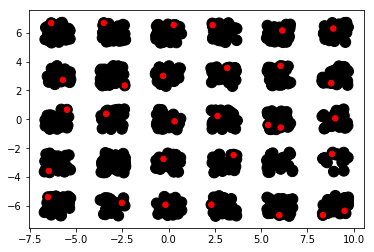

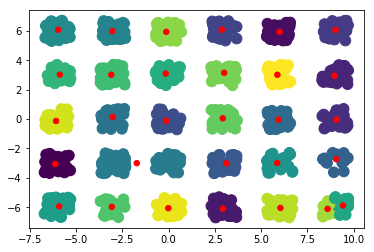

In [14]:
plot_result(points_assigned, init_centroids, True)
plot_result(points_assigned, centroids)

In [15]:
(points_assigned, centroids, init_centroids) = kmeans(file_name, k, init_kmeans_plus_plus, sc)

kmeans iteration 0
kmeans iteration 1
kmeans iteration 2
kmeans iteration 3
kmeans iteration 4


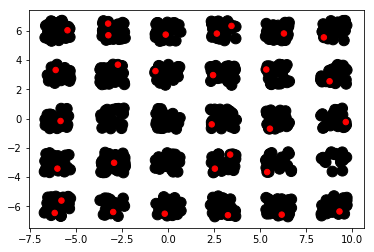

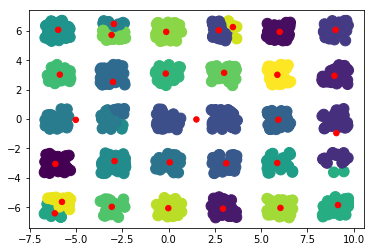

In [16]:
plot_result(points_assigned, init_centroids, True)
plot_result(points_assigned, centroids)